In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [327]:
def category_differences(train, test, col):
    train_minus_test = set(train.HomePlanet.unique()) - set(test.HomePlanet.unique())
    test_minus_train = set(test.HomePlanet.unique()) - set(train.HomePlanet.unique())
    print("categories that are in train but not in test for the column {} : {}".format(col, train_minus_test))
    print("categories that are in test but not in train for the column {} : {}".format(col, test_minus_train))

In [328]:
def seperate_types(df):
        num_con_cols = []
        num_disc_cols = []
        cat_cols = []

        for label, value in df.items():
            if pd.api.types.is_string_dtype(value):
                cat_cols.append(label)
            else:
                if df[label].nunique() > 100:
                    num_con_cols.append(label)
                else:
                    num_disc_cols.append(label)
        return num_con_cols, num_disc_cols, cat_cols

In [329]:
def plot_categories(df, var, target):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=90)

    ax2 = ax.twinx()
    ax.bar(df.index, df["perc_category"], color='lightgrey')
    ax2.plot(df.index, df[target], color='green', label='Seconds')
    ax.axhline(y=0.05, color='red')
    ax.set_ylabel('percentage of data per category')
    ax.set_xlabel(var)
    ax2.set_ylabel('Average Target per category')
    plt.show()

In [330]:
def calculate_mean_target_per_category(df, var, target):

    # total number of houses
    len_df = len(df)

    # percentage of houses per category
    temp_df = pd.Series(df[var].value_counts() / len_df).reset_index()
    temp_df.columns = [var, 'perc_category']

    # add the mean SalePrice
    temp_df = temp_df.merge(df.groupby([var])[target].mean().reset_index(),
                            on=var,
                            how='left')

    return temp_df

In [331]:
def unique_count(df, cols):
    for col in cols:
        print(f"{col} has {df[col].nunique()} unique categories")

In [332]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [333]:
sample_submission = pd.read_csv("sample_submission.csv")

In [334]:
sample_submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [335]:
#PassengerId and Name have no predictive power
train.drop(["PassengerId", "Name"], axis=1, inplace=True)
#but for the test set we need to store them in a variable before dropping.
test_passid = test.PassengerId
test.drop(["PassengerId", "Name"], axis=1, inplace=True)

In [336]:
#column length of train must be one more than test 
len(train.columns), len(test.columns)

(12, 11)

In [337]:
num_con_cols, num_disc_cols, cat_cols = seperate_types(train)

In [338]:
num_con_cols, num_disc_cols, cat_cols

(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
 ['Age', 'Transported'],
 ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'])

In [339]:
train.Cabin

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [340]:
#there are too many categories in cabin feature, we need to reduce it.
unique_count(train, cat_cols)

HomePlanet has 3 unique categories
CryoSleep has 2 unique categories
Cabin has 6560 unique categories
Destination has 3 unique categories
VIP has 2 unique categories


Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [341]:
#we will get only the deck and side information from the cabin feature
train.Cabin

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [342]:
train["Deck"] = train.Cabin.apply(lambda x: str(x)[0])
train["Side"] = train.Cabin.apply(lambda x: str(x)[-1])
test["Deck"] = test.Cabin.apply(lambda x: str(x)[0])
test["Side"] = test.Cabin.apply(lambda x: str(x)[-1])

train.drop("Cabin", axis=1, inplace=True)
test.drop("Cabin", axis=1, inplace=True)

cat_cols.remove("Cabin")
cat_cols.append("Deck")
cat_cols.append("Side")

In [343]:
train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,S


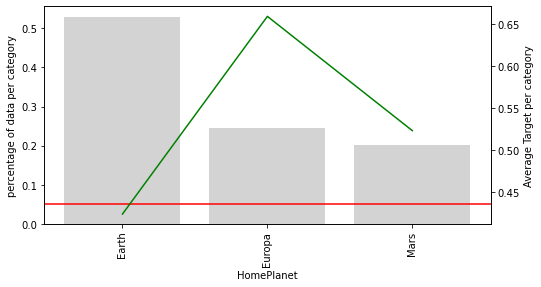

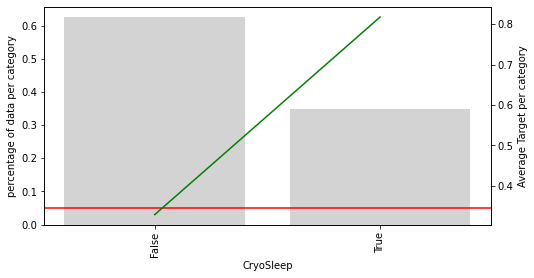

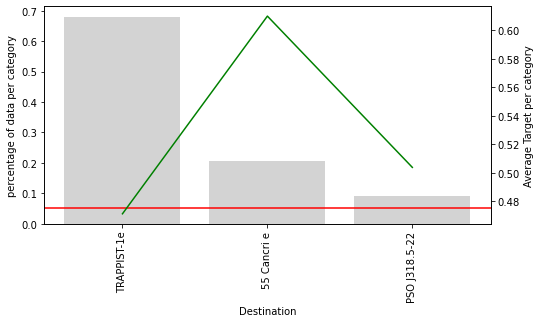

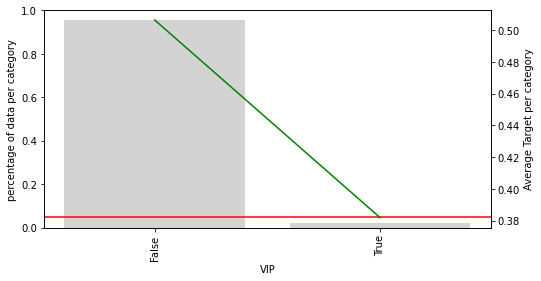

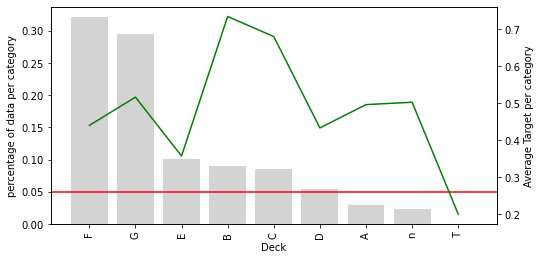

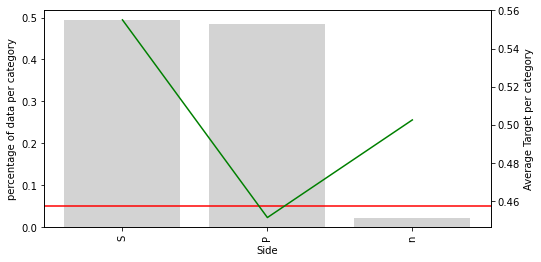

In [344]:
#let's visualize percentage of categories in each feature and their mean target
target = "Transported"
for col in cat_cols:
    temp = calculate_mean_target_per_category(train, col, target)
    plot_categories(temp, col, target)

In [345]:
#in the VIP feature percentage of values with True is 2.2%
train.loc[train.VIP==True, "VIP"].sum() / len(train)

0.02289198205452663

In [346]:
#in the test there are almost no values with True
test.loc[train.VIP==True, "VIP"].sum() / len(test)

0.0007014262333411269

From the plot we can see that VIP Feature has not many values with True
and we can drop the column altogether.

In [347]:
train.drop("VIP", axis=1, inplace=True)
test.drop("VIP", axis=1, inplace=True)
cat_cols.remove("VIP")

In [348]:
#age is numerical discrete variable, we could group them as young,middle-aged,and old.
#And add it to cat_cols
temp = pd.cut(train.Age, bins=3, labels=False)
temp_2 = pd.cut(test.Age, bins=3, labels=False)

In [349]:
#0's are young, 1's are middle-aged, 2's are old passengers
temp

0       1.0
1       0.0
2       2.0
3       1.0
4       0.0
       ... 
8688    1.0
8689    0.0
8690    0.0
8691    1.0
8692    1.0
Name: Age, Length: 8693, dtype: float64

In [350]:
age_dict = {0:"young", 1:"middle-aged", 2:"old"}
temp = temp.map(age_dict)
temp_2 = temp_2.map(age_dict)
temp.head()

0    middle-aged
1          young
2            old
3    middle-aged
4          young
Name: Age, dtype: object

In [351]:
temp_2.head()

0    middle-aged
1          young
2    middle-aged
3    middle-aged
4          young
Name: Age, dtype: object

In [352]:
train.Age = temp.copy()
test.Age = temp_2.copy()
del temp, temp_2

In [353]:
cat_cols.append("Age")
cat_cols

['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'Age']

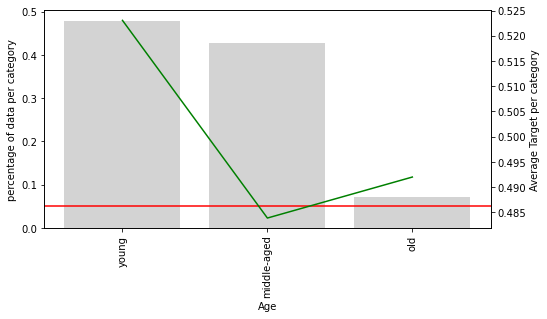

In [354]:
#let's visualize the behaviour of categories of age column
temp = calculate_mean_target_per_category(train, "Age", "Transported")
plot_categories(temp, "Age", "Transported")

### missing data imputation for categorical features

In [355]:
### Let's check if test dataset has any different values in categorical_columns compared to train dataset

In [356]:
#there aren't any different categories
for col in cat_cols:
    category_differences(train, test, col)
    print("*--------*")

categories that are in train but not in test for the column HomePlanet : set()
categories that are in test but not in train for the column HomePlanet : set()
*--------*
categories that are in train but not in test for the column CryoSleep : set()
categories that are in test but not in train for the column CryoSleep : set()
*--------*
categories that are in train but not in test for the column Destination : set()
categories that are in test but not in train for the column Destination : set()
*--------*
categories that are in train but not in test for the column Deck : set()
categories that are in test but not in train for the column Deck : set()
*--------*
categories that are in train but not in test for the column Side : set()
categories that are in test but not in train for the column Side : set()
*--------*
categories that are in train but not in test for the column Age : set()
categories that are in test but not in train for the column Age : set()
*--------*


# QUOTE from https://www.kaggle.com/code/ssarkar445/flying-machine-kfold-ensemble-starter-80-accuracy/notebook
**When CryoSleep is True all below services are not used so replace all the nans for below column with 0 if CryoSleep is True (RoomService,FoodCourt,ShoppingMall,Spa,VRDeck)**

In [357]:
train[num_con_cols].isna().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [358]:
cryo_true = train.loc[train.CryoSleep==True, num_con_cols].fillna(0)

In [359]:
#indexes where Cryo sleep is True
cryo_true_indexes = cryo_true.index

In [360]:
train.loc[cryo_true_indexes, num_con_cols] = cryo_true

In [361]:
train[num_con_cols].isna().sum()

RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
dtype: int64

In [362]:
test[num_con_cols].isna().sum()

RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

In [363]:
cryo_true = test.loc[test.CryoSleep==True, num_con_cols].fillna(0)
cryo_true_indexes = cryo_true.index
test.loc[cryo_true_indexes, num_con_cols] = cryo_true

In [364]:
test[num_con_cols].isna().sum()

RoomService     57
FoodCourt       67
ShoppingMall    63
Spa             59
VRDeck          51
dtype: int64

In [365]:
cat_cols

['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'Age']

In [366]:
#We are going to fill with the value 'missing'

In [367]:
for col in cat_cols:
    train[col].fillna("missing", inplace=True)
    test[col].fillna("missing", inplace=True)

In [368]:
train[cat_cols].isna().sum()

HomePlanet     0
CryoSleep      0
Destination    0
Deck           0
Side           0
Age            0
dtype: int64

In [369]:
test[cat_cols].isna().sum()

HomePlanet     0
CryoSleep      0
Destination    0
Deck           0
Side           0
Age            0
dtype: int64

### missing data imputation for numerical continuous features

In [370]:
for col in num_con_cols:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)

In [371]:
train.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Side            0
dtype: int64

In [372]:
test.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
Side            0
dtype: int64

### now we encode the categorical features

In [373]:
#we can one-hot  encode the features with no more than 5 categories
unique_count(train, cat_cols)

HomePlanet has 4 unique categories
CryoSleep has 3 unique categories
Destination has 4 unique categories
Deck has 9 unique categories
Side has 3 unique categories
Age has 4 unique categories


In [374]:
#and the for the cabin, we will encode them with target-encoding

In [375]:
cat_cols

['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side', 'Age']

In [376]:
one_hot_features = cat_cols.copy()
one_hot_features.remove("Deck")
dummies_train = pd.get_dummies(train[one_hot_features], drop_first=True)
dummies_test = pd.get_dummies(test[one_hot_features], drop_first=True)

In [377]:
train.drop(one_hot_features, axis=1, inplace=True)
test.drop(one_hot_features, axis=1, inplace=True)

In [378]:
train = pd.concat([train, dummies_train], axis=1)
test = pd.concat([test, dummies_test], axis=1)

In [379]:
len(train.columns), len(test.columns)

(20, 19)

In [380]:
deck_dict = train.groupby("Deck")["Transported"].mean()

In [381]:
deck_dict = dict(deck_dict)

In [382]:
train.Deck = train.Deck.map(deck_dict)
test.Deck = test.Deck.map(deck_dict)

In [383]:
train

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_missing,CryoSleep_True,CryoSleep_missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_missing,Side_S,Side_n,Age_missing,Age_old,Age_young
0,0.0,0.0,0.0,0.0,0.0,False,0.734275,1,0,0,0,0,0,1,0,0,0,0,0,0
1,109.0,9.0,25.0,549.0,44.0,True,0.439871,0,0,0,0,0,0,1,0,1,0,0,0,1
2,43.0,3576.0,0.0,6715.0,49.0,False,0.496094,1,0,0,0,0,0,1,0,1,0,0,1,0
3,0.0,1283.0,371.0,3329.0,193.0,False,0.496094,1,0,0,0,0,0,1,0,1,0,0,0,0
4,303.0,70.0,151.0,565.0,2.0,True,0.439871,0,0,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,False,0.496094,1,0,0,0,0,0,0,0,0,0,0,0,0
8689,0.0,0.0,0.0,0.0,0.0,False,0.516217,0,0,0,1,0,1,0,0,1,0,0,0,1
8690,0.0,0.0,1872.0,1.0,0.0,True,0.516217,0,0,0,0,0,0,1,0,1,0,0,0,1
8691,0.0,1049.0,0.0,353.0,3235.0,False,0.357306,1,0,0,0,0,0,0,0,1,0,0,0,0


In [384]:
test

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_missing,CryoSleep_True,CryoSleep_missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_missing,Side_S,Side_n,Age_missing,Age_old,Age_young
0,0.0,0.0,0.0,0.0,0.0,0.516217,0,0,0,1,0,0,1,0,1,0,0,0,0
1,0.0,9.0,0.0,2823.0,0.0,0.439871,0,0,0,0,0,0,1,0,1,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.680054,1,0,0,1,0,0,0,0,1,0,0,0,0
3,0.0,6652.0,0.0,181.0,585.0,0.680054,1,0,0,0,0,0,1,0,1,0,0,0,0
4,10.0,0.0,635.0,0.0,0.0,0.439871,0,0,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,0.0,0.0,0.0,0.0,0.516217,0,0,0,1,0,0,1,0,1,0,0,0,0
4273,0.0,847.0,17.0,10.0,144.0,0.502513,0,0,0,0,0,0,1,0,0,1,0,0,0
4274,0.0,0.0,0.0,0.0,0.0,0.433054,0,1,0,1,0,0,0,0,0,0,1,0,0
4275,0.0,2680.0,0.0,0.0,523.0,0.433054,1,0,0,0,0,0,0,1,0,0,1,0,0


In [385]:
X = train.drop("Transported", axis=1)
y = train.Transported.astype(int)

In [386]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RoomService                8693 non-null   float64
 1   FoodCourt                  8693 non-null   float64
 2   ShoppingMall               8693 non-null   float64
 3   Spa                        8693 non-null   float64
 4   VRDeck                     8693 non-null   float64
 5   Deck                       8693 non-null   float64
 6   HomePlanet_Europa          8693 non-null   uint8  
 7   HomePlanet_Mars            8693 non-null   uint8  
 8   HomePlanet_missing         8693 non-null   uint8  
 9   CryoSleep_True             8693 non-null   uint8  
 10  CryoSleep_missing          8693 non-null   uint8  
 11  Destination_PSO J318.5-22  8693 non-null   uint8  
 12  Destination_TRAPPIST-1e    8693 non-null   uint8  
 13  Destination_missing        8693 non-null   uint8

In [387]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Transported
Non-Null Count  Dtype
--------------  -----
8693 non-null   int32
dtypes: int32(1)
memory usage: 34.1 KB


In [388]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [389]:
clf.fit(X, y)

RandomForestClassifier()

In [390]:
clf.score(X, y)

0.922121246980329

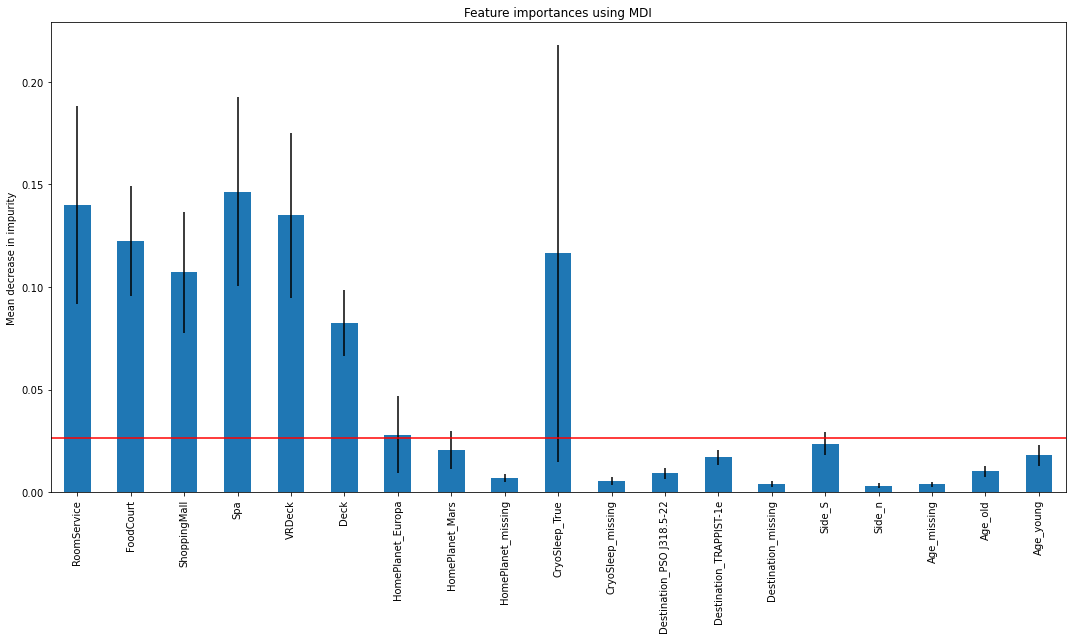

In [391]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(15, 9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.axhline(y=1/(len(X.columns) * 2), color='red')
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [392]:
unimportant_features = [forest_importances[forest_importances < 1/(len(X.columns) * 2)].index]

In [393]:
X.drop(unimportant_features[0], axis=1, inplace=True)

In [394]:
test.drop(unimportant_features[0], axis=1, inplace=True)

In [395]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

In [396]:
clf.score(X, y)

0.9119981594386288

In [397]:
X

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,HomePlanet_Europa,CryoSleep_True
0,0.0,0.0,0.0,0.0,0.0,0.734275,1,0
1,109.0,9.0,25.0,549.0,44.0,0.439871,0,0
2,43.0,3576.0,0.0,6715.0,49.0,0.496094,1,0
3,0.0,1283.0,371.0,3329.0,193.0,0.496094,1,0
4,303.0,70.0,151.0,565.0,2.0,0.439871,0,0
...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,0.496094,1,0
8689,0.0,0.0,0.0,0.0,0.0,0.516217,0,1
8690,0.0,0.0,1872.0,1.0,0.0,0.516217,0,0
8691,0.0,1049.0,0.0,353.0,3235.0,0.357306,1,0


In [128]:
preds = clf.predict(test)

In [129]:
sample_submission["Transported"] = preds

In [130]:
sample_submission.Transported = sample_submission.Transported.astype(bool)

In [131]:
sample_submission.to_csv("submission_3.csv", index=False)